# Informe Final Carrera
Profundiza y ajusta la resolución de tus proyectos: agrega al menos una fuente de datos o prueba un modelo que hasta el momento no hayas aplicado. Elabora un informe ?nal que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Dataset I

#### Explorando el Dataset

In [2]:
banksim = pd.read_csv('bs140513_032310.csv')

In [3]:
banksim.shape

(594643, 10)

In [4]:
banksim.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Step: Esta característica representa el día desde el comienzo de la simulación. Tiene 180 pasos, por lo que la simulación duró virtualmente 6 meses.  
Customer: Esta característica representa la identificación del cliente.  
zipCodeOrigin: El código postal de origen/fuente.  
Merchant: La identificación del comerciante.  
zipMerchant: El código postal del comerciante.  
Edad: Edad categorizada.  
0: <= 18,  
1: 19-25,  
2: 26-35,  
3: 36-45,  
4: 46:55,  
5: 56:65,  
6: > 65  
U: Desconocido  
Gender: Género para el cliente.  
E : Enterprise,  
F: Mujer,  
M: Hombre,  
U: Desconocido  
Category: Categoría de la compra. No escribiré todas las categorías aquí, las veremos más tarde en el análisis.  
Amount: Cantidad de la compra.  
Fraud: Variable objetivo que muestra si la transacción es fraudulenta(1).

In [5]:
banksim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [6]:
banksim.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
banksim['age'] = le.fit_transform(banksim['age'])
print(banksim['age'])

0         4
1         2
2         4
3         3
4         5
         ..
594638    3
594639    4
594640    2
594641    5
594642    4
Name: age, Length: 594643, dtype: int32


In [8]:
banksim[['step','age','amount']].describe().round()

,step,age,amount
count,594643.0,594643.0,594643.0
mean,95.0,3.0,38.0
std,51.0,1.0,111.0
min,0.0,0.0,0.0
25%,52.0,2.0,14.0
50%,97.0,3.0,27.0
75%,139.0,4.0,43.0
max,179.0,7.0,8330.0


In [9]:
banksim[['step','age','amount']].describe().round()

,step,age,amount
count,594643.0,594643.0,594643.0
mean,95.0,3.0,38.0
std,51.0,1.0,111.0
min,0.0,0.0,0.0
25%,52.0,2.0,14.0
50%,97.0,3.0,27.0
75%,139.0,4.0,43.0
max,179.0,7.0,8330.0


Los datos de los fraudes estarán desequilibrados como se ve en el gráfico de abajo y en el recuento de instancias. Para equilibrar el conjunto de datos se pueden realizar técnicas de sobremuestreo o submuestreo. El sobremuestreo es aumentar el número de la clase minoritaria generando instancias de la clase minoritaria. El submuestreo consiste en reducir el número de instancias de la clase mayoritaria mediante la selección de puntos aleatorios de la misma hasta que sea igual a la clase minoritaria. Ambas operaciones tienen algunos riesgos: El sobremuestreo creará copias o puntos de datos similares que a veces no serían útiles para el caso de la detección de fraudes porque las transacciones fraudulentas pueden variar. El submuestreo significa que perdimos puntos de datos y, por lo tanto, información. Realizaremos una técnica de sobremuestreo llamada SMOTE (Técnica de sobremuestreo de minorías sintéticas). SMOTE creará nuevos puntos de datos de la clase minoritaria utilizando las instancias vecinas, de modo que las muestras generadas no son copias exactas, sino que son similares a las instancias que tenemos.

#### Fraude

In [10]:
pd.unique(banksim['fraud'])

array([0, 1], dtype=int64)

In [11]:
print(banksim['fraud'].value_counts())

0    587443
1      7200
Name: fraud, dtype: int64


In [12]:
print(banksim['fraud'].value_counts().sum())

594643


Text(0.5, 1.0, 'Número de Customers')

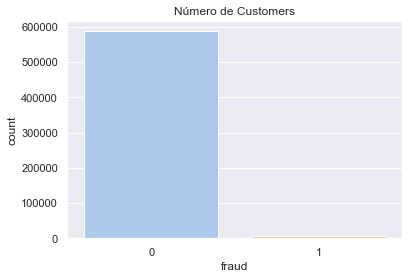

In [13]:
sns.countplot(data = banksim, x = 'fraud', order = banksim['fraud'].value_counts().index, palette='pastel')
plt.title('Número de Customers')

Podemos ver la cantidad media y el porcentaje de fraude por categoría a continuación. Parece que el ocio y los viajes son las categorías más seleccionadas por los defraudadores. Los defraudadores eligieron las categorías en las que la gente gasta más en promedio. Confirmemos esta hipótesis comprobando la cantidad de fraude y de no fraude que se ha tramitado.

In [14]:
print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())

Cantidad media y porcentaje por categoriaa                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


<ipython-input-14-e747060d8e56>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Cantidad media y porcentaje por categoriaa",banksim.groupby('category')['amount','fraud'].mean())


Nuestra hipótesis de que los defraudadores elijan las categorías en las que la gente gasta más es sólo parcialmente correcta, pero como podemos ver en el cuadro siguiente podemos decir con confianza que una transacción fraudulenta será mucho más (unas cuatro veces o más) que el promedio de esa categoría.

In [15]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = banksim.loc[banksim.fraud == 1] 
df_non_fraud = banksim.loc[banksim.fraud == 0]

In [16]:
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           banksim.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000
'es_sportsandtoys',345.366811,88.502738,49.525237


Las categorías de gasto promedio son similares; entre 0-500 descartando los valores atípicos, excepto la categoría de viajes que es muy alta.

No handles with labels found to put in legend.


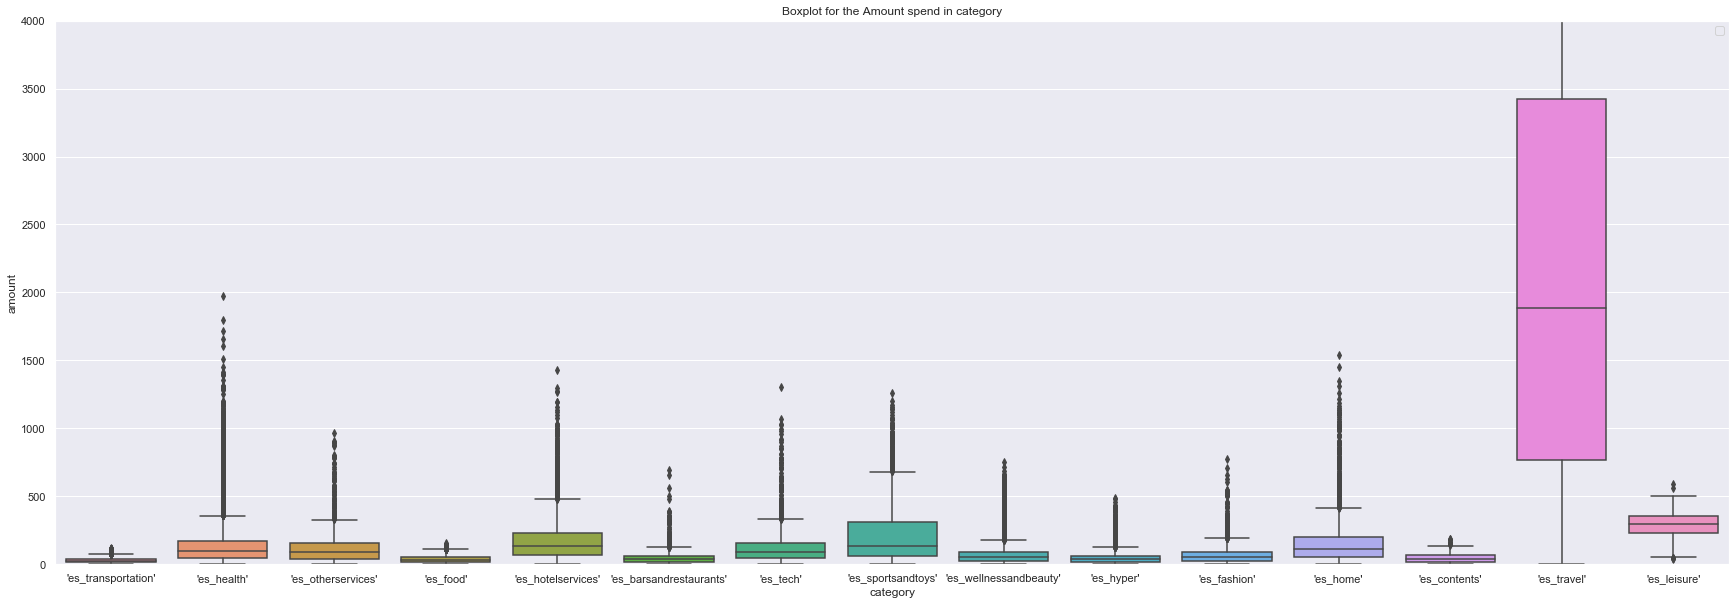

In [17]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=banksim.category,y=banksim.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

Una vez más podemos ver en el histograma de abajo que las transacciones fradulentas son menos en cuenta pero más en cantidad.

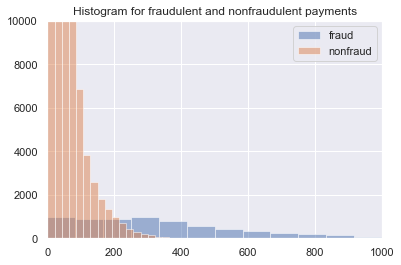

In [18]:
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

Con más de 400 ya poderíamos decir que haya fraude.

Parece que el fraude ocurre más en edades iguales y menores de 18 años (0º categoría). ¿Puede ser debido a que los estafadores piensan que habría menos consecuencias si muestran su edad más joven, o tal vez realmente son jóvenes.

In [19]:
print((banksim.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7    7       0.594228
6    6       0.974826
5    5       1.095112
1    1       1.185254
3    3       1.192815
2    2       1.251401
4    4       1.293281
0    0       1.957586


#### Cliente

In [20]:
pd.unique(banksim['customer'])

array(["'C1093826151'", "'C352968107'", "'C2054744914'", ...,
       "'C1014783484'", "'C849065220'", "'C1809646275'"], dtype=object)

In [21]:
print(banksim['customer'].value_counts())

'C1978250683'    265
'C1275518867'    252
'C806399525'     237
'C515668508'     205
'C1338396147'    195
                ... 
'C1345586046'      6
'C1156745710'      6
'C1809646275'      5
'C1743702978'      5
'C1404665203'      5
Name: customer, Length: 4112, dtype: int64


In [22]:
print(banksim['customer'].value_counts().sum())

594643


In [23]:
#sns.countplot(data = banksim, y = 'customer', order = banksim['customer'].value_counts().index, palette='pastel')
#plt.title('Número de Customers')

#### Pasos

In [24]:
pd.unique(banksim['step'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179], d

In [25]:
print(banksim['step'].value_counts())

175    3774
177    3758
152    3746
178    3743
174    3743
       ... 
5      2525
3      2499
2      2462
0      2430
1      2424
Name: step, Length: 180, dtype: int64


In [26]:
print(banksim['step'].value_counts().sum())

594643


#### Zip Code

In [27]:
pd.unique(banksim['zipcodeOri'])

array(["'28007'"], dtype=object)

In [28]:
print(banksim['zipcodeOri'].value_counts())

'28007'    594643
Name: zipcodeOri, dtype: int64


In [29]:
print(banksim['zipcodeOri'].value_counts().sum())

594643


In [30]:
pd.unique(banksim['zipMerchant'])

array(["'28007'"], dtype=object)

In [31]:
print(banksim['zipMerchant'].value_counts())

'28007'    594643
Name: zipMerchant, dtype: int64


In [32]:
print(banksim['zipMerchant'].value_counts().sum())

594643


#### Categoria

In [33]:
pd.unique(banksim['category'])

array(["'es_transportation'", "'es_health'", "'es_otherservices'",
       "'es_food'", "'es_hotelservices'", "'es_barsandrestaurants'",
       "'es_tech'", "'es_sportsandtoys'", "'es_wellnessandbeauty'",
       "'es_hyper'", "'es_fashion'", "'es_home'", "'es_contents'",
       "'es_travel'", "'es_leisure'"], dtype=object)

In [34]:
print(banksim['category'].value_counts())

'es_transportation'        505119
'es_food'                   26254
'es_health'                 16133
'es_wellnessandbeauty'      15086
'es_fashion'                 6454
'es_barsandrestaurants'      6373
'es_hyper'                   6098
'es_sportsandtoys'           4002
'es_tech'                    2370
'es_home'                    1986
'es_hotelservices'           1744
'es_otherservices'            912
'es_contents'                 885
'es_travel'                   728
'es_leisure'                  499
Name: category, dtype: int64


In [35]:
print(banksim['category'].value_counts().sum())

594643


#### Monto

In [36]:
pd.unique(banksim['amount'])

array([  4.55,  39.68,  26.89, ..., 249.18, 224.81, 190.31])

In [37]:
print(banksim['amount'].value_counts())

14.93     146
26.67     146
17.57     145
17.26     143
16.12     143
         ... 
751.43      1
274.43      1
517.95      1
105.02      1
429.60      1
Name: amount, Length: 23767, dtype: int64


In [38]:
print(banksim['amount'].value_counts().sum())

594643


### Correlaciones

In [44]:
from sklearn.preprocessing import OneHotEncoder

oe = OneHotEncoder()
banksim['gender'] = le.fit_transform(banksim['gender'])
print(banksim['gender'])

0         2
1         2
2         1
3         2
4         2
         ..
594638    1
594639    1
594640    1
594641    2
594642    1
Name: gender, Length: 594643, dtype: int32


In [41]:
banksim['category'] = le.fit_transform(banksim['category'])
print(banksim['category'])

0         12
1         12
2         12
3         12
4         12
          ..
594638    12
594639    12
594640     2
594641    12
594642    12
Name: category, Length: 594643, dtype: int32


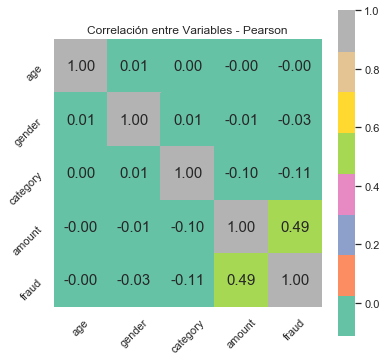

In [45]:
corr = banksim[['age','gender','category','amount','fraud']].corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15}, cmap= 'Set2')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Correlación entre Variables - Pearson')
plt.show()

In [47]:
df = pd.get_dummies(banksim, columns=['category'])
print (df)

        step       customer  age  gender zipcodeOri       merchant  \
0          0  'C1093826151'    4       2    '28007'   'M348934600'   
1          0   'C352968107'    2       2    '28007'   'M348934600'   
2          0  'C2054744914'    4       1    '28007'  'M1823072687'   
3          0  'C1760612790'    3       2    '28007'   'M348934600'   
4          0   'C757503768'    5       2    '28007'   'M348934600'   
...      ...            ...  ...     ...        ...            ...   
594638   179  'C1753498738'    3       1    '28007'  'M1823072687'   
594639   179   'C650108285'    4       1    '28007'  'M1823072687'   
594640   179   'C123623130'    2       1    '28007'   'M349281107'   
594641   179  'C1499363341'    5       2    '28007'  'M1823072687'   
594642   179   'C616528518'    4       1    '28007'  'M1823072687'   

       zipMerchant  amount  fraud  category_0  ...  category_5  category_6  \
0          '28007'    4.55      0           0  ...           0           0   
1  